### This notebook contains the final exam of the microsoft professional capstone project

#### Goal:
Your goal is to predict whether a mortgage application was accepted (meaning the loan was originated) or denied according to the given dataset, which is adapted from the Federal Financial Institutions Examination Council's (FFIEC).

#### Performance Metric:
We're predicting a binary variable, so this is a classification problem. To measure classification, we'll use a metric known as accuracy (also known as "classification rate"). Accuracy is one metric for evaluating classification models. Informally, accuracy is the fraction of predictions our model got right. For binary classification, accuracy can be calculated in terms of positives and negatives as follows:

In [ ]:
!pip install git+https://github.com/MaxHalford/xam --upgrade

  Cloning https://github.com/MaxHalford/xam to /tmp/pip-req-build-dwv_56od
  Running command git clone -q https://github.com/MaxHalford/xam /tmp/pip-req-build-dwv_56od
  Stored in directory: /tmp/pip-ephem-wheel-cache-9f558sjp/wheels/c1/26/e2/f6ff22ce0373264c4474074284a7773437559dffabe7457895
Successfully built xam


In [1]:
#import neccessary modules and libraries for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xam

#Makes graph display in notebook
%matplotlib inline   

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics

ModuleNotFoundError: No module named 'xam'

In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
train_link = 'https://drive.google.com/open?id=1Lqth0JiX5IbE0dJ9_QMm6hVSLMu0knqq'
test_link = 'https://drive.google.com/open?id=1S1vSS2XSBi0Uk9su1nhrpBePRmXL53QF'
train_label_link = 'https://drive.google.com/open?id=1MOph7VJXpwENelvAT5YrTv3mudDQdPZx'
submission_link = 'https://drive.google.com/open?id=1aCg8vOD2zpPhEqBJza3RY4JhIYxVFRFB'

# link_list = [train_link, train_label, test_link]

fluff, id = train_link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train_values.csv')  
train_data = pd.read_csv('train_values.csv')


fluff, id = test_link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('test_values.csv')  
test_data = pd.read_csv('test_values.csv')

fluff, id = train_label_link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train_labels.csv')  
train_label = pd.read_csv('train_labels.csv')

fluff, id = submission_link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('submission.csv')  
submission_sample = pd.read_csv('submission.csv')



In [ ]:
#Display a sample of data sets
train_data.head()

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant
0,0,3,1,1,1,70.0,3,18,37,246,2,5,1,24.0,6203.0,44.230,60588.0,50.933,716.0,2642.0,4536,False
1,1,1,1,3,1,178.0,3,369,52,299,1,5,1,57.0,5774.0,15.905,54821.0,100.000,1622.0,2108.0,2458,False
2,2,2,1,3,1,163.0,3,16,10,306,2,5,1,67.0,6094.0,61.270,67719.0,100.000,760.0,1048.0,5710,False
3,3,1,1,1,1,155.0,1,305,47,180,2,5,1,105.0,6667.0,6.246,78439.0,100.000,2025.0,2299.0,5888,True
4,4,1,1,1,1,305.0,3,24,37,20,2,3,2,71.0,6732.0,100.000,63075.0,82.200,1464.0,1847.0,289,False


In [ ]:
test_data.head()

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant
0,0,2,1,3,1,115.0,3,101,16,276,2,5,1,NaN,6329.0,59.536,69889.0,85.78,1874.0,2410.0,3791,True
1,1,1,1,1,1,252.0,2,87,20,68,2,5,1,107.0,2473.0,8.050,65313.0,100.00,947.0,1214.0,2839,True
2,2,1,1,1,1,270.0,1,-1,-1,-1,2,1,2,119.0,NaN,NaN,NaN,NaN,NaN,NaN,4701,False
3,3,2,1,1,1,179.0,2,376,20,11,2,2,2,44.0,4795.0,29.676,57766.0,100.00,1426.0,1765.0,2153,True
4,4,2,1,1,1,36.0,2,254,48,156,3,6,3,32.0,5246.0,5.110,63332.0,100.00,1452.0,2092.0,5710,False


### Features Description
There are 21 variables in this dataset. Each row in the dataset represents a HMDA-reported loan application, and the dataset we are working with covers one particular year.

We provide a unique identifier called lender for each individual loan-making institution.

The variables are as follows:

#### PROPERTY LOCATION
msa_md (categorical) - A categorical with no ordering indicating Metropolitan Statistical Area/Metropolitan Division where a value of -1 indicates a missing value
state_code (categorical) - A categorical with no ordering indicating the U.S. state where a value of -1 indicates a missing value
county_code (categorical) - A categorical with no ordering indicating the county where a value of -1 indicates a missing value

#### LOAN INFORMATION
lender (categorical) - A categorical with no ordering indicating which of the lenders was the authority in approving or denying this loan

loan_amount (int) - Size of the requested loan in thousands of dollars

loan_type (categorical) - Indicates whether the loan granted, applied for, or purchased was conventional, government-guaranteed, or government-insured; available values are:

1 -- Conventional (any loan other than FHA, VA, FSA, or RHS loans)
2 -- FHA-insured (Federal Housing Administration)
3 -- VA-guaranteed (Veterans Administration)
4 -- FSA/RHS (Farm Service Agency or Rural Housing Service)

property_type (categorical) - Indicates whether the loan or application was for a one-to-four-family dwelling (other than manufactured housing), manufactured housing, or multifamily dwelling; available values are:

1 -- One to four-family (other than manufactured housing)
2 -- Manufactured housing
3 -- Multifamily

loan_purpose (categorical) - Indicates whether the purpose of the loan or application was for home purchase, home improvement, or refinancing; available values are:

1 -- Home purchase
2 -- Home improvement
3 -- Refinancing

occupancy (categorical) - Indicates whether the property to which the loan application relates will be the owner's principal dwelling; available values are:

1 -- Owner-occupied as a principal dwelling
2 -- Not owner-occupied
3 -- Not applicable

preapproval (categorical) - Indicate whether the application or loan involved a request for a pre-approval of a home purchase loan; available values are:

1 -- Preapproval was requested
2 -- Preapproval was not requested
3 -- Not applicable

#### APPLICANT INFORMATION
applicant_income (int) - In thousands of dollars

applicant_ethnicity (categorical) - Ethnicity of the applicant; available values are:

1 -- Hispanic or Latino
2 -- Not Hispanic or Latino
3 -- Information not provided by applicant in mail, Internet, or telephone pplication
4 -- Not applicable
5 -- No co-applicant

applicant_race (categorical) - Race of the applicant; available values are:

1 -- American Indian or Alaska Native
2 -- Asian
3 -- Black or African American
4 -- Native Hawaiian or Other Pacific Islander
5 -- White
6 -- Information not provided by applicant in mail, Internet, or telephone application
7 -- Not applicable
8 -- No co-applicant

applicant_sex (categorical) - Sex of the applicant; available values are:

1 -- Male
2 -- Female
3 -- Information not provided by applicant in mail, Internet, or telephone application
4 or 5 -- Not applicable
co_applicant (bool) - Indicates whether there is a co-applicant (often a spouse) or not

#### CENSUS INFORMATION
population - Total population in tract
minority_population_pct - Percentage of minority population to total population for tract
ffiecmedian_family_income - FFIEC Median family income in dollars for the MSA/MD in which the tract is located (adjusted annually by FFIEC)
tract_to_msa_md_income_pct - % of tract median family income compared to MSA/MD median family income
number_of_owner-occupied_units - Number of dwellings, including individual condominiums, that are lived in by the owner
number_of_1_to_4_family_units - Dwellings that are built to house fewer than 5 families

#### INDEX AND TARGET VARIABLE
row_id - A unique identifier with no intrinsic meaning, but the IDs in your submission must match the submission format exactly
accepted - Indicates whether the mortgage application was accepted (successfully originated) with a value of 1 or denied with a value of 0

In [ ]:
train_label.head()

,row_id,accepted
0,0,1
1,1,0
2,2,1
3,3,1
4,4,1


In [ ]:
#merge labels with data set for exploration
train_full = pd.merge(train_data, train_label, how="left", on="row_id")
train_full.head(2)

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant,accepted
0,0,3,1,1,1,70.0,3,18,37,246,2,5,1,24.0,6203.0,44.230,60588.0,50.933,716.0,2642.0,4536,False,1
1,1,1,1,3,1,178.0,3,369,52,299,1,5,1,57.0,5774.0,15.905,54821.0,100.000,1622.0,2108.0,2458,False,0


## Let's perform some statistics on the data

In [ ]:
#get shape
train_full.shape

(500000, 23)

In [ ]:
train_full.describe()

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,accepted
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,460052.000000,477535.000000,477534.000000,477560.000000,477486.000000,477435.000000,477470.000000,500000.000000,500000.000000
mean,249999.500000,1.366276,1.047650,2.066810,1.109590,221.753158,2.764722,181.606972,23.726924,144.542062,2.036228,4.786586,1.462374,102.389521,5416.833956,31.617310,69235.603298,91.832624,1427.718282,1886.147065,3720.121344,0.500228
std,144337.711634,0.690555,0.231404,0.948371,0.326092,590.641648,0.543061,138.464169,15.982768,100.243612,0.511351,1.024927,0.677685,153.534496,2728.144999,26.333938,14810.058791,14.210924,737.559511,914.123744,1838.313175,0.500000
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,14.000000,0.534000,17858.000000,3.981000,4.000000,1.000000,0.000000,0.000000
25%,124999.750000,1.000000,1.000000,1.000000,1.000000,93.000000,3.000000,25.000000,6.000000,57.000000,2.000000,5.000000,1.000000,47.000000,3744.000000,10.700000,59731.000000,88.067250,944.000000,1301.000000,2442.000000,0.000000
50%,249999.500000,1.000000,1.000000,2.000000,1.000000,162.000000,3.000000,192.000000,26.000000,131.000000,2.000000,5.000000,1.000000,74.000000,4975.000000,22.901000,67526.000000,100.000000,1327.000000,1753.000000,3731.000000,1.000000
75%,374999.250000,2.000000,1.000000,3.000000,1.000000,266.000000,3.000000,314.000000,37.000000,246.000000,2.000000,5.000000,2.000000,117.000000,6467.000000,46.020000,75351.000000,100.000000,1780.000000,2309.000000,5436.000000,1.000000
max,499999.000000,4.000000,3.000000,3.000000,3.000000,100878.000000,3.000000,408.000000,52.000000,324.000000,4.000000,7.000000,4.000000,10139.000000,37097.000000,100.000000,125248.000000,100.000000,8771.000000,13623.000000,6508.000000,1.000000


In [ ]:
#seperate small categorical features from numerical features
cat_feats = ["loan_purpose", "occupancy", "preapproval","loan_type", "property_type", 
             "applicant_ethnicity", "applicant_race", "applicant_sex", "co_applicant"
            ]

num_feats = ['loan_amount','applicant_income', 'population', 'minority_population_pct',
               'ffiecmedian_family_income', 'tract_to_msa_md_income_pct',
               'number_of_owner-occupied_units', 'number_of_1_to_4_family_units'
            ]

The categorical features have been encoded with numbers, we'll map them to their corresponding values and save in a new data frame for doing visualization.

In [ ]:
code_list = [['loan_purpose', 
              {1 : 'Home-purchase', 
               2 : 'Home-improvement', 
               3 : 'Refinancing'}],
             
            ['occupancy',
            {1 : 'Owner-occupied', 
             2 : 'Not-owner-occupied', 
             3 : 'Not-applicable'}],
             
            ['preapproval',
            {1 : 'Preapproval-requested', 
             2 : 'Preapproval-not-requested',
             3 : 'Not-applicable'}],
             
            ['loan_type',
            {1 : 'Conventional', 
             2 : 'FHA', 
             3 : 'VA', 
             4 : 'FSA/RHS'}],
             
            ['property_type',
            {1 : 'One-to-four-family',
             2 : 'Manufactured-housing', 
             3 : 'Multifamily'}],
             
            ['applicant_ethnicity',
            {1 : 'Hispanic/Latino', 
             2 : 'Not-Hispanic/Latino',
             3 : 'Not-provided ', 
             4 : 'Not-applicable', 
             5 : 'No-co-applicant'}],
             
            ['applicant_race',
            {1 : 'American-Indian/Alaska-Native', 
             2 : 'Asian', 
             3 : 'Black/African-American', 
             4 : 'Native-Hawaiian/Islander', 
             5 : 'White', 
             6 : 'Not-provided', 
             7 : 'Not-applicable', 
             8 : 'No-co-applicant'}],
             
            ['applicant_sex',
            {1 : 'Male',
             2 : 'Female', 
             3 : 'Not-provided',
             4 : 'Not-applicable' }]
            
            ]

#Save edited data set to new variable used for EDA only
train_2_plot = train_full

for feat_dic in code_list:
    col = feat_dic[0]
    dic = feat_dic[1]
    train_2_plot[col] = [dic[x] for x in train_2_plot[col]]
    test_data[col] = [dic[x] for x in test_data[col]]   #Test set

    
train_2_plot.head()
    

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant,accepted
0,0,VA,One-to-four-family,Home-purchase,Owner-occupied,70.0,Not-applicable,18,37,246,Not-Hispanic/Latino,White,Male,24.0,6203.0,44.230,60588.0,50.933,716.0,2642.0,4536,False,1
1,1,Conventional,One-to-four-family,Refinancing,Owner-occupied,178.0,Not-applicable,369,52,299,Hispanic/Latino,White,Male,57.0,5774.0,15.905,54821.0,100.000,1622.0,2108.0,2458,False,0
2,2,FHA,One-to-four-family,Refinancing,Owner-occupied,163.0,Not-applicable,16,10,306,Not-Hispanic/Latino,White,Male,67.0,6094.0,61.270,67719.0,100.000,760.0,1048.0,5710,False,1
3,3,Conventional,One-to-four-family,Home-purchase,Owner-occupied,155.0,Preapproval-requested,305,47,180,Not-Hispanic/Latino,White,Male,105.0,6667.0,6.246,78439.0,100.000,2025.0,2299.0,5888,True,1
4,4,Conventional,One-to-four-family,Home-purchase,Owner-occupied,305.0,Not-applicable,24,37,20,Not-Hispanic/Latino,Black/African-American,Female,71.0,6732.0,100.000,63075.0,82.200,1464.0,1847.0,289,False,1


In [ ]:
# check number of unique values in categoricals
for feat in cat_feats:
    print('Value Count for', feat)
    print(train_2_plot[feat].value_counts())
    print("---------------------------")

Value Count for loan_purpose
Refinancing         242670
Home-purchase       209265
Home-improvement     48065
Name: loan_purpose, dtype: int64
---------------------------
Value Count for occupancy
Owner-occupied        447394
Not-owner-occupied     50417
Not-applicable          2189
Name: occupancy, dtype: int64
---------------------------
Value Count for preapproval
Not-applicable               411109
Preapproval-not-requested     60143
Preapproval-requested         28748
Name: preapproval, dtype: int64
---------------------------
Value Count for loan_type
Conventional    370827
FHA              82430
VA               39521
FSA/RHS           7222
Name: loan_type, dtype: int64
---------------------------
Value Count for property_type
One-to-four-family      478217
Manufactured-housing     19741
Multifamily               2042
Name: property_type, dtype: int64
---------------------------
Value Count for applicant_ethnicity
Not-Hispanic/Latino    386061
Not-provided            57298
Hispa

## Exploratory data analysis

Let's explore the categorical features first

### CHART FOR REPORT

In [ ]:
dic = {"White" : "White",
      "Black/African-American": "Blacks/Asians/None",
      "Not-provided": "Blacks/Asians/None",
      "Asian": "Blacks/Asians/None",
      "American-Indian/Alaska-Native": "Others",
      "Not-applicable": "Others",
      "Native-Hawaiian/Islander": "Others"}

train_2_plot['applicant_race_joined'] = train_2_plot['applicant_race'].map(dic)
train_2_plot['applicant_race_joined'].unique()

array(['White', 'Blacks/Asians/None', 'Others'], dtype=object)

Text(0.5, 1.0, 'Bar plot for Applicant race')

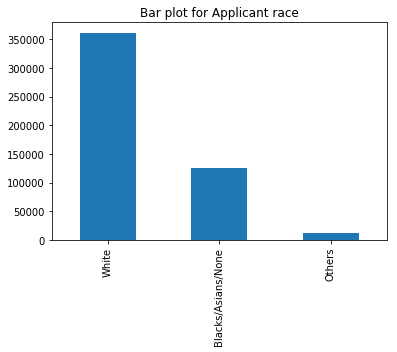

In [ ]:
train_2_plot['applicant_race_joined'].value_counts().plot.bar()
plt.title("Bar plot for Applicant race")

### Barplot

In [ ]:
def plot_bar(data, cat_feats):
    for feat in cat_feats:
        fig = plt.figure(figsize=((5,5)))
        ax = fig.gca()

        #get the value count of the column
        v_count = data[feat].value_counts()
        v_count.plot.bar(ax = ax)
        ax.set_title("Bar plot for " + feat)
        
# plot_bar(train_2_plot, cat_feats)
    

### VISUALIZATION FOR NUMERICAL FEATURES USING BOXPLOT AND VIOLIN PLOT

In [ ]:
def plot_box(train_2_plot, cols, col_x = 'accepted'):
    for col in cols:
        sns.set_style("whitegrid")
        sns.boxplot(col_x, col, data=train_2_plot)
        plt.xlabel(col_x) # Set text for the x axis
        plt.ylabel(col)# Set text for y axis
        plt.show()


plot_box(train_2_plot, num_feats)

In [ ]:
def plot_violin(train_2_plot, cols, col_x = 'accepted'):
    for col in cols:
        sns.set_style("whitegrid")
        sns.violinplot(col_x, col, data=train_2_plot)
        plt.xlabel(col_x) # Set text for the x axis
        plt.ylabel(col)# Set text for y axis
        plt.show()


plot_violin(train_2_plot, num_feats)

### HISTOGRAM DISTRIBUTION OF NUMERICAL FEATURES

In [ ]:
def plot_histogram(train_2_plot, cols, bins = 8):
    for col in cols:
        fig = plt.figure(figsize=(6,6)) # define plot area
        ax = fig.gca() # define axis    
        train_2_plot[col].plot.hist(ax = ax, bins = bins) # Use the plot.hist method on subset of the data frame
        ax.set_title('Histogram of ' + col) # Give the plot a main title
        ax.set_xlabel(col) # Set text for the x axis
        ax.set_ylabel('Count')# Set text for y axis
        plt.show()
        
plot_histogram(train_2_plot, num_feats)

### VISUALIZATION FOR CATEGORICAL FEATURES

In [ ]:
def plot_categoricals_2_label(data, label_name, cat_cols):
    # Create a dummy column to hold sum/count of values
    data['dummy_count'] = np.ones(shape = data.shape[0])
    #Loop over each categorical feature and plot the acceptance rate for each category.
    for col in cat_cols:
        print(col)
        counts = data[['dummy_count', label_name, col]].groupby([label_name, col], as_index = False).count() #get the counts for each category

        _ = plt.figure(figsize = (10,4))
        plt.subplot(1, 2, 1)
        temp = counts[counts[label_name] == 0][[col, 'dummy_count']]  #Get the counts where loan was rejected
        plt.bar(temp[col], temp.dummy_count)
        plt.xticks(rotation=90)
        plt.title('Counts for ' + col + '\n Rejected Loans')
        plt.ylabel('count')

        plt.subplot(1, 2, 2)
        temp = counts[counts[label_name] == 1][[col, 'dummy_count']]  #Get the counts where loan was rejected
        plt.bar(temp[col], temp.dummy_count)
        plt.xticks(rotation=90)
        plt.title('Counts for ' + col + '\n Accepted Loans')
        plt.ylabel('count')
        plt.show()


plot_categoricals_2_label(train_2_plot, "accepted", cat_feats)

In [ ]:
sns.pairplot(train_2_plot[num_feats])

EXPLORATIONS TO ANSWER EXAM QUESTIONS

In [ ]:
sub_set = train_2_plot[train_2_plot['state_code'] == 45][["applicant_income","loan_amount"]]
sub_set.head()

In [ ]:
sub_set.plot.scatter(x='applicant_income', y='loan_amount')

In [ ]:
sub_set = train_2_plot[(train_2_plot['state_code'] == 2) | (train_2_plot['state_code'] == 4)][["loan_type","accepted", "state_code"]]
sub_set.head()

In [ ]:
loan_typ = ['Conventional', 'VA', 'FHA', 'FSA/RHS']
states = [2,4]

for state in states:
    print("State "+ str(state))
    for l_type in loan_typ:
        print("Loan Type: " + l_type)
        accep = sub_set[(sub_set['loan_type'] == l_type) & (sub_set['state_code'] == state) & (sub_set['accepted'] == 1)]['accepted']
        print("Acceptance rate for state " + str(state) + " and loantype of " + str(l_type) + " is: " + str(accep.sum() / sub_set.shape[0]))

        
        

### FEATURE ENGINEERING

According to the problem description, some missing values in msa_md, state_code and county_code are were replaced with -1. we'll replace these values with NAN.

Create new columns that would record if a value was missing or not before we perform imputation

In [ ]:
def add_nan_cols(train, test, replace= False, replace_val= -1, display= False):
    #Replace any encoded missing values with NAN
    if replace:
        train = train.replace(replace_val, np.nan)
        test = test.replace(replace_val, np.nan)
        
    #get columns with NAN values
    temp = train.isna().sum() != 0
    cols = temp[temp == True].index
        
    for col in cols:
        train[col + "_NAN"] = train[col].notnull().astype('int')
        test[col + "_NAN"] = test[col].notnull().astype('int')
        
    if display:
        print("-------------------------------------------")
        print("Table of Train data")
        print(train[train == -1].sum())
        print("-------------------------------------------")
        print("Table of Test data")
        print(test[test == -1].sum())
    
    return (train, test)
        
        
train, test = add_nan_cols(train_2_plot, test_data, replace=True, display=False)

### Bin counting Lender column

In [ ]:
# # For a categorical, we want to calculate theta = [counts, p(accepted), p(rejected), p(accepted) /p(rejected)]

# def accept_count(df, bin_column):
#     accepted = pd.Series(df[df['accepted'] > 0][bin_column].value_counts(), name='accepted')
#     rejected = pd.Series(df[df['accepted'] < 1][bin_column].value_counts(), name='rejected')
    
#     counts = pd.DataFrame([accepted, rejected]).T.fillna('0')
#     #get total counts
#     counts['total_accepted'] = counts['accepted'].astype('int64') + counts['rejected'].astype('int64')
#     counts['']
#     return counts


# def bin_counting(counts):
#     counts['probs_accepted'] =  counts['accepted'].astype('int64').divide(counts['total_accepted'].astype('int64'))
#     counts['probs_rejected'] =  counts['rejected'].astype('int64').divide(counts['total_accepted'].astype('int64'))
# #     counts['probs_combined'] =  counts['probs_accepted'].divide(counts['probs_rejected'])
    
#     return counts

In [ ]:
means = train.groupby(['lender']).agg({'accepted': ['mean']}).reset_index()

In [ ]:
# Merge to train and test set
train = train.merge(means, how='left', on='lender')
test = test.merge(means, how='left', on='lender')

In [ ]:
labels = train['accepted'].values
train.drop(['accepted', 'row_id'], axis=1, inplace=True)
test.drop(['row_id'], axis=1, inplace=True)

### Log transform numerical data

In [ ]:
def log_transform(num_feats, df):
    for col in num_feats:
        df[col] = np.log10(df[col] + 1)
        
    return df

train = log_transform(num_feats, train)
test = log_transform(num_feats, test)

In [ ]:
# plot_histogram(train, num_feats)

### TARGET ENCODE LARGE CATEGORICALS

In [ ]:
cat_2_enc = ['msa_md', 'state_code', 'county_code', 'lender']
encoder = xam.feature_extraction.BayesianTargetEncoder(
            columns=cat_2_enc,
            prior_weight=10,
            suffix=''
        )

train_enc = encoder.fit_transform(train, pd.Series(labels))
test_enc = encoder.transform(test)

#### Dummy Encode categorical variables

In [ ]:
def dummy_encode_data(train, test):
    #First we concatenate train and test set
    ntrain = train.shape[0]
    ntest = test.shape[0]

    all_data = pd.concat((train,test)).reset_index(drop=True)
    #drop target variable
#     all_data.drop(['accepted'], axis=1, inplace=True)
    print("Total data size is after concatenation: {}".format(all_data.shape))
    
    #Dummy encode
    all_data = pd.get_dummies(all_data)
    print('Data size after dummy encoding: ' + str(all_data.shape))
    
    #Lets get the new train and test set
    train_temp = all_data[:ntrain]
    test_temp = all_data[ntrain:]

    print('Train size: ' + str(train_temp.shape))
    print('Test size: ' + str(test_temp.shape))
    
    return (train_temp, test_temp)

In [ ]:
train_enc, test_enc = dummy_encode_data(train_enc, test_enc)

Total data size is after concatenation: (1000000, 32)
Data size after dummy encoding: (1000000, 55)
Train size: (500000, 55)
Test size: (500000, 55)


In [ ]:
!pip install catboost

     |████████████████████████████████| 61.2MB 67.7MB/s 


### MODELLING 

In [ ]:
from sklearn.preprocessing import StandardScaler,Imputer,RobustScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from catboost import CatBoostClassifier

import xgboost as xgb
import lightgbm as lgb

In [ ]:
def impute_and_scale(train, test):
    impute = SimpleImputer(strategy='mean')
    impute.fit(train)
    train = impute.transform(train)
    test = impute.transform(test)
    
    scaler = StandardScaler()
    scaler.fit(train)
    train = scaler.transform(train)
    test = scaler.transform(test)
    
    return (train, test)


train_enc, test_enc = impute_and_scale(train_enc, test_enc)

In [ ]:
# ### Create pairwise features
# poly = PolynomialFeatures(include_bias=False, interaction_only=True)

# train_enc = poly.fit_transform(train_enc)
# test_enc = poly.transform(test_enc)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_enc, labels, test_size = 0.2)

print("shape of training data is", X_train.shape)
print("shape of training target is", y_train.shape)
print("shape of test data is", X_val.shape)
print("shape of test target is", y_val.shape)

shape of training data is (400000, 55)
shape of training target is (400000,)
shape of test data is (100000, 55)
shape of test target is (100000,)


### MODELLING

In [ ]:
def train_and_predict(train, label, val, val_label, model):
    model.fit(train, label)
    pred = model.predict(val)
    acc = accuracy_score(val_label, pred)
    f1 = f1_score(val_label, pred)
    precision = precision_score(val_label, pred)
    recall = recall_score(val_label, pred)
    confusion_mat = confusion_matrix(val_label, pred)
    
    print("Accuracy is ", round(acc * 100))
    print("F1 score is ", round(f1 * 100))
    print("Precision is ", round(precision * 100))
    print("Recall is ", round(recall * 100))
    print("confusion Matrix is ", confusion_mat)
    
    fpr, tpr, thresholds = roc_curve(val_label, pred)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    # show the plot
    plt.title("roc curve for the model")
    plt.show()
    plt.savefig("roc_plot.png")



In [ ]:
logreg = LogisticRegression()

randforest_model = RandomForestClassifier(n_estimators=200, max_depth=7,
                                          random_state=232)

lgb_model = lgb.LGBMClassifier(n_estimators=500, random_state=232, learning_rate=0.1)

xb_model = xgb.XGBClassifier(n_estimators=1000, random_state=232, learning_rate=0.1)

gbmodel = GradientBoostingClassifier(n_estimators=200)

cat_model = CatBoostClassifier(
                    iterations=500,
                    learning_rate=0.03,
                    task_type='GPU',
                    eval_metric = 'Accuracy',
                    )
  
    

In [ ]:
# # param_lgb ={'num_leaves': [40,50,60], 
# #             'max_depth':  [5,6,7], 
# #             'learning_rate':  [0.01, 0.1, 0.2], 
# #              'min_child_samples':  [15,20,30], 
# #              'min_child_weight': [1e-5, 1e-3, 1e-2 ],
# #              'reg_alpha': [0, 1e-1, 1],
# #              'reg_lambda': [0, 1e-1, 1]}


# params_cat = {'depth':[3,1,2,6,4,5,7,8],
#           'iterations':[250,100,500,1000],
#           'learning_rate':[0.03,0.001,0.01,0.1,0.2], 
#           'l2_leaf_reg':[3,1,5,10,100],
#           'border_count':[32,5,10,20,50,100],
#           'thread_count':[4]}




# gs = GridSearchCV(cat_model, params_cat, cv=3)
          

# gs.fit(X_train, y_train)
# print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

In [ ]:
# fit_params={"early_stopping_rounds":30, 
#             "eval_metric" : 'accuracy', 
#             "eval_set" : [(X_val,y_val)],
#             'eval_names': ['valid'],
#             #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
#             'verbose': 100,
#             'categorical_feature': 'auto'}



# from scipy.stats import randint as sp_randint
# from scipy.stats import uniform as sp_uniform

# param_test ={'num_leaves': sp_randint(6, 50), 
#              'min_child_samples': sp_randint(100, 500), 
#              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#              'subsample': sp_uniform(loc=0.2, scale=0.8), 
#              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
#              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


# clf = lgb.LGBMClassifier(random_state=314, silent=True, metric='None', n_jobs=-1, n_estimators=1000)

# gs_sample_weight = GridSearchCV(estimator=clf_sw, 
#                                 scoring='accuracy',
#                                 cv=3,
#                                 refit=True,
#                                 verbose=True)

# gs_sample_weight.fit(X_train, y_train, **fit_params)
# print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))

In [ ]:
# train_and_predict(X_train, y_train, X_val, y_val, lgb_model)

# # model.fit(
# #     X_train, y_train,
# #     eval_set=(X_test, y_test),
# #     verbose=10
# # ); 

In [ ]:
def make_sub_csv(test, model, csv_file, label_name, train_full_dataset = False, data = None, label = None):
    '''Creates and return a submission CSV file'''
    
    if train_full_dataset:
        model.fit(data,label)
        pred = model.predict(test)
        
        csv_file[label_name] = pred
        csv_file.to_csv("submit1.csv", index=False)
        csv_file.head()
        return

    
    pred = model.predict(test)
    csv_file[label_name] = pred
    csv_file.to_csv("submit1.csv", index=False)
    csv_file.head()
    
    return


In [ ]:
# make_sub_csv(test, lgb_model, submission_format, 
#              label_name="accepted",
#              train_full_dataset=True,
#              data=train, label=label)

In [ ]:
opt_param = {'reg_lambda': 0, 'reg_alpha': 1,
             'num_leaves': 50, 'min_child_weight': 1e-05, 
             'min_child_samples': 30, 
             'max_depth': 6, 'learning_rate': 0.2} 

lgb_model.set_params(**opt_param)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.2, max_depth=6,
               min_child_samples=30, min_child_weight=1e-05, min_split_gain=0.0,
               n_estimators=500, n_jobs=-1, num_leaves=50, objective=None,
               random_state=232, reg_alpha=1, reg_lambda=0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
bagg_model = BaggingClassifier(lgb_model)

Accuracy is  73.0
F1 score is  74.0
Precision is  71.0
Recall is  77.0
confusion Matrix is  [[34134 15732]
 [11362 38772]]


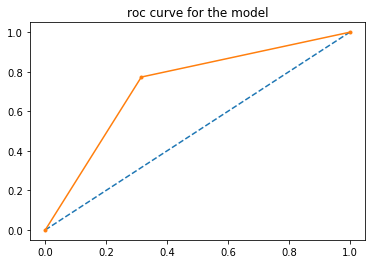

<Figure size 432x288 with 0 Axes>

In [ ]:
train_and_predict(X_train, y_train, X_val, y_val, lgb_model)

### RANDOM SEARCH FOR OPTIMAL HYPERPARAMETERS USING LGBM BOOAST

In [ ]:
# param_test ={'num_leaves': [40,50,60], 
#             'max_depth':  [5,6,7], 
#             'learning_rate':  [0.01, 0.1, 0.2], 
#              'min_child_samples':  [15,20,30], 
#              'min_child_weight': [1e-5, 1e-3, 1e-2 ],
#              'reg_alpha': [0, 1e-1, 1],
#              'reg_lambda': [0, 1e-1, 1]}


# clf = lgb.LGBMClassifier(random_state=314,
#                          silent=True, metric='None',
#                          n_estimators=400)

# fit_params={"early_stopping_rounds":30, 
#             "eval_metric" : 'auc', 
#             "eval_set" : [(X_val,y_val)],
#             'eval_names': ['valid'],
#             'verbose': 100,
#             'categorical_feature': 'auto'}

# gs = RandomizedSearchCV(
#     estimator=clf, param_distributions=param_test, 
#     n_iter=10,
#     scoring='roc_auc',
#     cv=3,
#     refit=True,
#     random_state=314,
#     verbose=True)

# gs.fit(X_train, y_train, **fit_params)
# print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

In [ ]:
opt_param = {'reg_lambda': 0, 'reg_alpha': 1,
             'num_leaves': 50, 'min_child_weight': 1e-05, 
             'min_child_samples': 30, 
             'max_depth': 6, 'learning_rate': 0.2} 

lgb_model.set_params(**opt_param)

In [ ]:
train_and_predict(X_train, y_train, X_val, y_val, lgb_model)

TARGET ENCODING